#  MNIST

the MNIST dataset, which is a set of 70,000
small images of digits handwritten by high school students and employees of
the US Census Bureau.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
mnist = fetch_openml("mnist_784", as_frame= False)

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- sklearn.datasets provides three main types of dataset functions:
  - fetch_* → downloads real-world datasets from the internet (e.g., fetch_openml)
  - load_* → loads small toy datasets bundled with scikit-learn (no internet needed)
  - make_* → generates synthetic/fake datasets for testing and experiments

- make_* functions usually return a tuple (X, y):
  - X → input features as a NumPy array
  - y → target labels as a NumPy array

- fetch_* and load_* functions usually return a Bunch object:
  - behaves like a dictionary with attribute-style access

- Common entries in a Bunch object:
  - DESCR → dataset description
  - data → input features (usually a 2D NumPy array)
  - target → labels (usually a 1D NumPy array)

- fetch_openml() is different by default:
  - returns inputs as a Pandas DataFrame
  - returns labels as a Pandas Series

- For image datasets like MNIST:
  - Pandas DataFrames are not ideal
  - use as_frame=False to get NumPy arrays instead


In [7]:
X,y = mnist.data, mnist.target

In [8]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [9]:
X.shape

(70000, 784)

In [10]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [11]:
y.shape

(70000,)

- MNIST contains 70,000 handwritten digit images
- Each image has 784 features because:
  - image size = 28 × 28 pixels
  - 28 × 28 = 784
- Each feature represents the intensity of one pixel
  - value range: 0 (white) to 255 (black)

- To visualize a digit:
  - select one row (feature vector) from the dataset
  - reshape it into a 28 × 28 array
  - display it using matplotlib.pyplot.imshow()

- Use cmap="binary":
  - grayscale color map
  - 0 → white
  - 255 → black


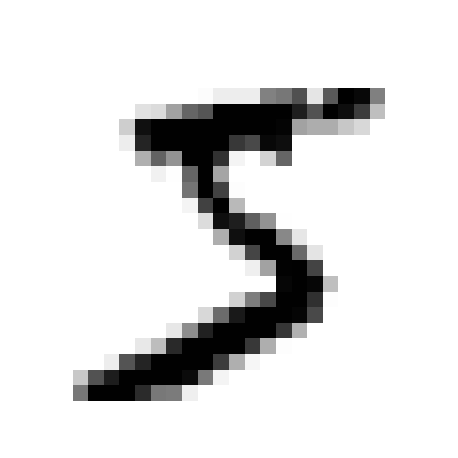

In [12]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit =X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()

In [13]:
y[0]

'5'

- Looking at multiple MNIST images helps understand the complexity and variability of handwritten digit classification

- Before closely inspecting or visualizing data, a test set should always be created and kept aside to avoid data leakage and biased evaluation

- The MNIST dataset from fetch_openml() is already split:
  - first 60,000 images → training set
  - last 10,000 images → test set

- The training set is already shuffled:
  - ensures each cross-validation fold contains a good mix of all digits
  - prevents any fold from missing certain classes

- Shuffling is important because:
  - some learning algorithms are sensitive to the order of training data
  - seeing many similar instances in sequence can degrade model performance

- A shuffled dataset leads to more reliable training and evaluation


In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

simplifying problem to identify if it's 5 or not

In [15]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

- Choose a classifier to begin training on the MNIST dataset
- A common and effective starting point is the Stochastic Gradient Descent (SGD) classifier
- SGDClassifier is designed to handle very large datasets efficiently

- Key reason for efficiency:
  - SGD processes training instances one at a time (or in small batches)
  - does not require loading the entire dataset into memory at once

- Because of this behavior, SGD is:
  - fast
  - memory-efficient
  - suitable for large-scale learning problems

- SGD is also well suited for online learning:
  - the model can be updated incrementally as new data arrives

- The next step is to create an SGDClassifier instance and train it using the full training set


In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [18]:
digit = X[1]

In [19]:
sgd_clf.predict([digit])

array([False])

In [20]:
y[1]

'0'

In [21]:
# now lets work on the performance

# Performance Measure

Evaluating a classifier is often significantly trickier than evaluating a
regressor, so we will spend a large part of this chapter on this topic.

## Measuring Accuracy Using Cross-Validation

- Model evaluation should be done using cross-validation rather than a single train–test split

- k-fold cross-validation works by:
  - splitting the training data into k equal folds
  - training the model k times
  - each time, one fold is held out for evaluation and the remaining folds are used for training

- In 3-fold cross-validation:
  - the training set is split into 3 folds
  - the model is trained 3 times
  - each fold is used once as a validation set

- cross_val_score() automates this process:
  - trains the model multiple times
  - evaluates it on different validation folds
  - returns an array of performance scores

- This method provides a more reliable estimate of model performance than a single evaluation


In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- Achieving over 95% accuracy across all cross-validation folds may look impressive at first

- However, accuracy alone can be misleading, especially for imbalanced datasets

- In the MNIST binary classification task (5 vs not 5):
  - the majority of images are NOT the digit 5
  - predicting "not 5" most of the time already yields high accuracy

- A dummy classifier can be used as a baseline:
  - it always predicts the most frequent class
  - in this case, it predicts the negative class (non-5)

- If a simple dummy classifier achieves similar accuracy:
  - the high accuracy of the real model is not meaningful
  - better evaluation metrics are required (precision, recall, confusion matrix)

- This demonstrates why accuracy should not be trusted blindly for classification problems


In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
dummy_clf = DummyClassifier(random_state=42)

In [26]:
dummy_clf.fit(X_train, y_train_5)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'prior'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [27]:
print(any(dummy_clf.predict(X_train)))

False


In [28]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3 , scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

- A dummy classifier achieves over 90% accuracy by always predicting "not 5"

- This happens because:
  - only about 10% of MNIST images are the digit 5
  - predicting the majority class gives high accuracy by default

- High accuracy in this case does not indicate a good classifier
  - it does not truly identify the digit 5
  - it only exploits class imbalance

- This example shows why accuracy is a poor metric for skewed datasets
  - where one class appears far more frequently than others

- For imbalanced classification problems:
  - accuracy can be misleading
  - more informative metrics are needed

- A better way to evaluate classifier performance is using the confusion matrix
  - it shows the number of correct and incorrect predictions for each class
  - helps understand the types of errors made by the model


## IMPLEMENTING CROSS-VALIDATION

when we need more control over cross validation then what is given by cross_val_score

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


- `skfolds.split(X_train, y_train_5)` performs stratified k-fold splitting on the dataset
- It generates indices for training and testing data for each fold
- `train_index` contains row indices used for training in the current fold
- `test_index` contains row indices used for validation in the current fold
- Stratification ensures each fold has a similar proportion of classes (5 vs not-5)
- The loop runs once per fold (3 times when n_splits=3)
- Indices are used to slice NumPy arrays, not to create copies of the data
- Each fold is used exactly once as the validation set
- This approach provides a fair and reliable evaluation of the model


## Confusion Matrices

- A confusion matrix counts how often instances of one class are predicted as another class
- Rows represent actual (true) classes
- Columns represent predicted classes

- Each cell (row A, column B) shows:
  - how many times class A was classified as class B
  - example: row 8, column 0 → number of 8s predicted as 0s

- To build a confusion matrix, predicted labels must be compared with true labels

- The test set should not be used at this stage
  - it must remain untouched until final model evaluation
  - using it early can lead to biased performance estimates

- Instead of using the test set:
  - generate predictions using cross-validation

- cross_val_predict():
  - returns predictions for each training instance
  - each prediction is made by a model that never saw that instance during training
  - enables safe construction of a confusion matrix without data leakage


In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_predict() works similarly to cross_val_score()
  - it performs k-fold cross-validation

- Key difference:
  - cross_val_score() returns evaluation scores
  - cross_val_predict() returns predicted labels

- Each prediction is made on a validation fold
  - the model has never seen that instance during training
  - predictions are therefore out-of-sample (“clean”)

- This produces one prediction for every instance in the training set
  - without touching the test set
  - avoids data leakage

- These clean predictions can now be compared with true labels

- confusion_matrix() is then used by passing:
  - actual target labels (y_train_5)
  - predicted labels (y_train_pred)

- The resulting confusion matrix shows how well the classifier distinguishes between classes


In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
cm = confusion_matrix(y_train_5, y_train_pred)

In [33]:
cm

array([[53892,   687],
       [ 1891,  3530]])

- In a confusion matrix:
  - rows represent the actual (true) classes
  - columns represent the predicted classes

- First row corresponds to non-5 images (negative class):
  - 53,892 correctly predicted as non-5 → true negatives (TN)
  - 687 incorrectly predicted as 5 → false positives (FP), also called type I errors

- Second row corresponds to images of 5 (positive class):
  - 1,891 incorrectly predicted as non-5 → false negatives (FN), also called type II errors
  - 3,530 correctly predicted as 5 → true positives (TP)

- Interpretation of errors:
  - false positives → model raises a false alarm
  - false negatives → model misses a true positive

- A perfect classifier:
  - has only true positives and true negatives
  - has zero false positives and false negatives
  - shows nonzero values only along the main diagonal of the confusion matrix


In [34]:
y_train_perfect_prediction = y_train_5

In [35]:
confusion_matrix(y_train_5,y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

- The confusion matrix is very informative, but sometimes a single concise metric is preferred

- Precision measures how accurate the positive predictions are
  - it answers: “When the model predicts positive, how often is it correct?”

- Precision formula:
  - precision = TP / (TP + FP)
  - TP → true positives
  - FP → false positives

- A classifier can achieve perfect precision by:
  - predicting positive only once
  - being correct for that one prediction
  - but such a classifier is not useful in practice

- High precision alone is not sufficient
  - the model may ignore most positive instances

- Recall (also called sensitivity or true positive rate) measures:
  - how many actual positive instances are correctly identified

- Recall formula:
  - recall = TP / (TP + FN)
  - FN → false negatives

- Precision and recall are usually used together
  - precision focuses on prediction quality
  - recall focuses on detection completeness


## precision and recall

In [36]:
from sklearn.metrics import precision_score, recall_score

In [37]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [38]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [39]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [40]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

- The classifier’s performance looks weaker when evaluated beyond accuracy
  - precision = 83.7% → when the model predicts a 5, it is correct 83.7% of the time
  - recall = 65.1% → the model detects only 65.1% of all actual 5s

- This shows that:
  - many 5s are being missed (false negatives)
  - accuracy alone hid these weaknesses

- Precision and recall are often combined into a single metric called the F1 score
  - useful when comparing multiple classifiers with one number

- The F1 score is the harmonic mean of precision and recall
  - it gives more weight to low values
  - a low precision or low recall will strongly reduce the F1 score

- F1 score formula:
  - F1 = 2 × (precision × recall) / (precision + recall)
  - equivalently: F1 = TP / (TP + (FN + FP)/2)

- A classifier gets a high F1 score only if:
  - both precision and recall are high


$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

$$
F_1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}}
$$

$$
F_1 = \frac{2 \times \text{Precision} \times \text{Recall}}
{\text{Precision} + \text{Recall}}
$$

$$
F_1 = \frac{TP}{TP + \frac{FN + FP}{2}}
$$


In [41]:
from sklearn.metrics import f1_score

In [42]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

- The F1 score favors classifiers where precision and recall are balanced
- However, balanced precision and recall are not always desirable in real-world applications

- In some cases, precision is more important than recall:
  - example: detecting videos safe for kids
  - high precision is critical to avoid showing unsafe content
  - low recall is acceptable if some safe videos are rejected
  - false positives are far worse than false negatives
  - a human review pipeline may be added for extra safety

- In other cases, recall is more important than precision:
  - example: detecting shoplifters in surveillance footage
  - high recall ensures almost all shoplifters are caught
  - low precision is acceptable, even with many false alarms
  - false negatives are more costly than false positives

- Precision and recall cannot both be maximized at the same time
  - increasing precision usually decreases recall
  - increasing recall usually decreases precision

- This inverse relationship is known as the precision–recall trade-off


## The Precision/Recall Trade-off

- SGDClassifier makes predictions using a decision function
  - it computes a score for each instance
  - this score reflects how confident the classifier is

- A decision threshold is used to assign classes:
  - if score ≥ threshold → positive class
  - if score < threshold → negative class

- Instances can be ordered from lowest to highest score
  - lower scores → more likely negative
  - higher scores → more likely positive

- With a middle threshold:
  - 4 true positives (actual 5s correctly detected)
  - 1 false positive (a 6 classified as a 5)
  - precision = 4 / 5 = 80%
  - recall = 4 / 6 ≈ 67%

- Raising the threshold:
  - false positives decrease
  - precision increases (can reach 100%)
  - some true positives become false negatives
  - recall decreases (e.g., to 50%)

- Lowering the threshold:
  - more instances are classified as positive
  - recall increases
  - precision decreases

- This behavior explains the precision–recall trade-off:
  - adjusting the threshold improves one metric at the cost of the other


- Scikit-Learn classifiers do not allow direct setting of the decision threshold

- Instead, they provide access to the raw decision scores used for prediction

- The decision_function() method:
  - returns a numerical score for each instance
  - higher scores indicate stronger confidence in the positive class

- Normally, predict() applies a default threshold internally
  - typically zero for many classifiers

- By using decision_function(), you can:
  - obtain the scores for all instances
  - manually choose any threshold
  - convert scores into class predictions yourself

- This allows fine control over:
  - precision–recall trade-off
  - false positives vs false negatives


In [43]:
y_scores = sgd_clf.decision_function([some_digit])

In [44]:
y_scores

array([2164.22030239])

In [45]:
threshold = 0

In [46]:
y_some_digit_pred = (y_scores>threshold)

In [47]:
y_some_digit_pred

array([ True])

In [48]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

In [49]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- Increasing the decision threshold reduces recall
  - some true positives fall below the higher threshold
  - actual positive instances may be missed

- In the example:
  - the image is a true 5
  - it is correctly detected when the threshold is 0
  - it is missed when the threshold is increased to 3000

- Choosing an appropriate threshold requires analyzing performance at different threshold values

- First, obtain decision scores for all training instances:
  - use cross_val_predict()
  - request decision scores instead of class predictions
  - this ensures scores are out-of-sample and unbiased

- Next, evaluate performance across thresholds:
  - use precision_recall_curve()
  - computes precision and recall for all possible thresholds

- The function also adds:
  - a final precision value of 0
  - a final recall value of 1
  - corresponding to an infinite decision threshold

- These curves help visualize and choose a threshold that best balances precision and recall for the task


In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [52]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447], shape=(60000,))

In [53]:
precisions

array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
       1.        ], shape=(60001,))

In [54]:
recalls

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00], shape=(60001,))

In [55]:
thresholds

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905],
      shape=(60000,))

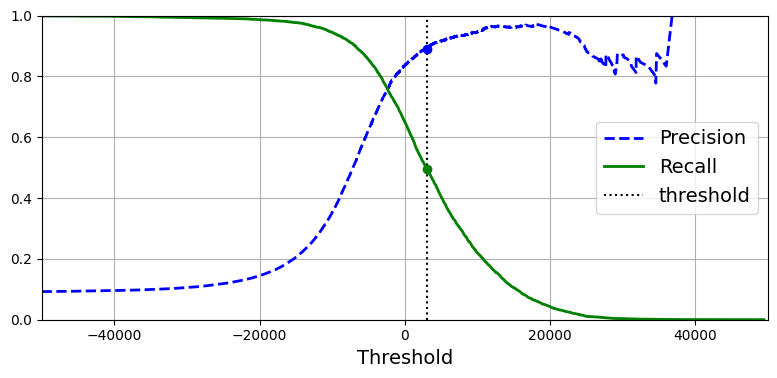

In [56]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

- The precision curve often appears bumpier than the recall curve

- Precision does not always increase when the threshold is raised
  - it can temporarily decrease

- Reason:
  - moving the threshold slightly may remove a true positive
  - while still keeping some false positives
  - example: precision drops from 4/5 (80%) to 3/4 (75%)

- Precision depends on both:
  - true positives (TP)
  - false positives (FP)
  - small changes in predictions can affect this ratio irregularly

- Recall behaves differently:
  - recall = TP / (TP + FN)
  - increasing the threshold can only reduce TP or leave it unchanged
  - recall never increases when the threshold goes up

- Because recall decreases monotonically:
  - its curve looks smooth
  - precision fluctuates, making its curve bumpier


At this threshold value, precision is near 90% and recall is around 50%.
Another way to select a good precision/recall trade-off is to plot precision
directly against recall

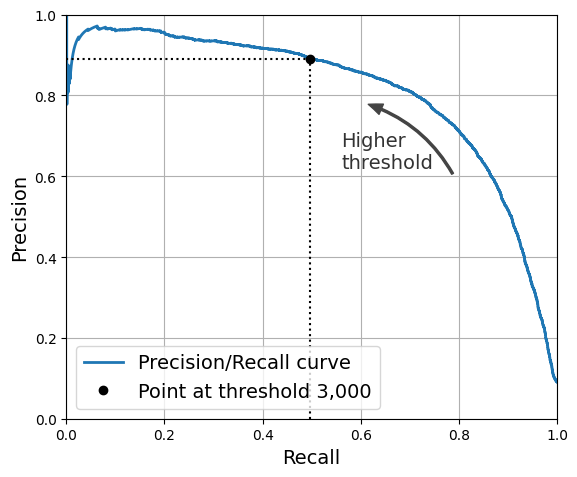

In [57]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

- Precision–recall curves help identify where model performance starts to degrade
  - in this case, precision drops sharply when recall goes beyond ~80%
  - a reasonable operating point may be just before this drop (e.g., ~60% recall)

- The optimal precision–recall trade-off depends on project requirements
  - there is no universally best threshold

- If a specific precision target is required (e.g., 90% precision):
  - visually estimating the threshold from the plot is imprecise
  - a programmatic approach is preferred

- The goal is to find the smallest threshold that achieves at least the desired precision

- This can be done using NumPy’s argmax() method:
  - create a boolean condition: precision ≥ desired precision
  - argmax() returns the index of the first True value
  - this index corresponds to the lowest threshold meeting the precision goal

- Using this threshold ensures:
  - the required precision is achieved
  - recall is as high as possible under that precision constraint


In [58]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

To make predictions (on the training set for now), instead of calling the
classifier’s predict() method, you can run this code

In [59]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [60]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [61]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

- Achieving high precision is often easy
  - increase the decision threshold
  - fewer instances are classified as positive
  - false positives drop sharply

- However, high precision alone does not guarantee a useful classifier
  - increasing precision usually lowers recall
  - many true positives may be missed

- In this example:
  - precision reaches 90%
  - recall drops to about 48%
  - more than half of the actual positives are not detected

- For many real-world applications:
  - such low recall is unacceptable
  - missing true positives can be costly

- Therefore, precision should never be considered in isolation

- When someone proposes a very high precision (e.g., 99%):
  - the critical follow-up question is:
    - “At what recall?”

- A good classifier must be evaluated using both precision and recall together
  - always consider the trade-off between them


## The ROC Curve

- The ROC (Receiver Operating Characteristic) curve is another evaluation tool for binary classifiers

- Unlike the precision–recall curve:
  - ROC plots True Positive Rate (TPR) vs False Positive Rate (FPR)

- Definitions:
  - True Positive Rate (TPR) = Recall = TP / (TP + FN)
  - False Positive Rate (FPR) = FP / (FP + TN)
  - True Negative Rate (TNR) = TN / (TN + FP)
  - FPR = 1 − TNR

- Terminology:
  - TPR is also called sensitivity
  - TNR is also called specificity
  - FPR is also called fall-out

- Therefore:
  - ROC curve plots sensitivity (recall)
  - against 1 − specificity

- To draw the ROC curve:
  - use the roc_curve() function
  - it computes TPR and FPR for different decision thresholds


In [62]:
from sklearn.metrics import roc_curve

In [63]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [64]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
       1.        ], shape=(3908,))

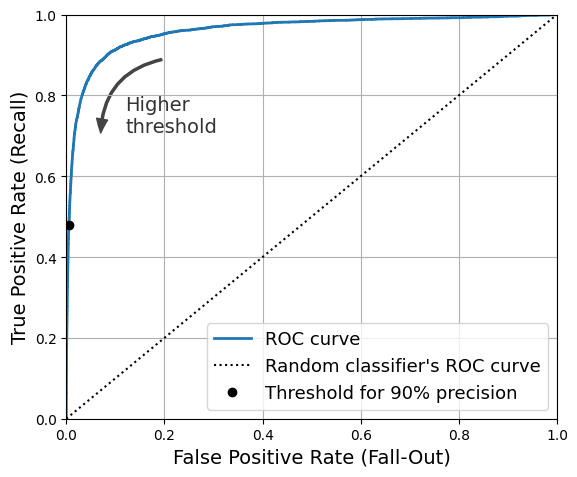

In [65]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

- The ROC curve also shows a trade-off:
  - increasing recall (TPR) usually increases false positives (FPR)

- As the decision threshold is lowered:
  - more positive predictions are made
  - TPR increases
  - FPR also increases

- The dotted diagonal line in the ROC plot represents:
  - a purely random classifier
  - TPR ≈ FPR at all thresholds

- A good classifier:
  - stays as far away from the diagonal line as possible
  - moves toward the top-left corner of the plot
    - high TPR
    - low FPR

- Classifiers can be compared using the Area Under the Curve (AUC):
  - ROC AUC measures the overall ability to separate positive and negative classes

- Interpretation of ROC AUC:
  - AUC = 1.0 → perfect classifier
  - AUC = 0.5 → random guessing
  - higher AUC → better classifier

- Scikit-Learn provides built-in functions to compute ROC AUC


In [66]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- ROC and Precision–Recall (PR) curves are closely related, but they are useful in different situations

- Prefer the PR curve when:
  - the positive class is rare (class imbalance)
  - false positives are more costly than false negatives

- Prefer the ROC curve when:
  - classes are more balanced
  - false positives and false negatives have similar importance

- ROC curves can appear overly optimistic on imbalanced datasets
  - a classifier may achieve a high ROC AUC
  - even if its performance on the positive class is not very strong

- In the MNIST case:
  - digit 5 is rare compared to non-5
  - ROC AUC suggests strong performance
  - PR curve reveals significant room for improvement

- PR curves are more informative for imbalanced classification problems
  - they better highlight precision and recall trade-offs


In [67]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a RandomForestClassifier, whose PR curve and F score we
can compare to those of the SGDClassifier

In [68]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

- precision_recall_curve() requires:
  - true labels
  - a score for each instance

- For RandomForestClassifier:
  - decision_function() is not available
  - this is due to how random forests operate internally

- Instead, RandomForestClassifier provides predict_proba():
  - returns the probability of each class for every instance

- The probability of the positive class can be used as a decision score
  - higher probability → higher confidence in positive class

- These probability scores are compatible with precision_recall_curve()

- To obtain clean (out-of-sample) probability scores:
  - use cross_val_predict()
  - train the RandomForestClassifier using cross-validation
  - request predicted probabilities for each instance

- This allows fair comparison with other classifiers
  - without touching the test set
  - while avoiding data leakage


In [69]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [70]:
 y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and
it predicts that the second image is negative with 99% probability. Since each
image is either positive or negative, the probabilities in each row add up to
100%.

- The probabilities returned by predict_proba() are estimated probabilities, not true probabilities

- These estimates may be poorly calibrated:
  - predicted probability ranges may not match actual outcome frequencies
  - example: instances predicted with 50–60% probability may actually be positive ~94% of the time

- In this case:
  - the model is underconfident (probabilities too low)
  - models can also be overconfident in other situations

- Poorly calibrated probabilities can be misleading
  - especially when probabilities are used for decision-making

- Scikit-Learn provides calibration tools:
  - available in the sklearn.calibration package
  - used to adjust predicted probabilities to better reflect true likelihoods

- Probability calibration is an advanced topic
  - discussed further in the extra material of the chapter’s notebook


In [71]:
# Not in the code
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [72]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

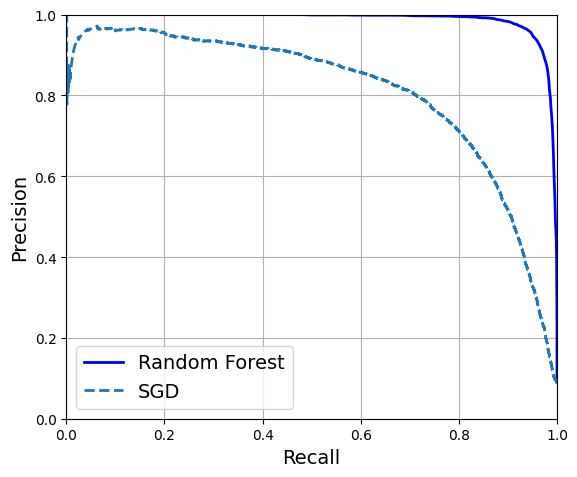

In [73]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

the RandomForestClassifier’s PR curve looks
much better than the SGDClassifier’s: it comes much closer to the top-right
corner. Its F score and ROC AUC score are also significantly better

In [74]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [75]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- Measuring performance shows strong results:
  - precision ≈ 99.1% → when the classifier predicts positive, it is almost always correct
  - recall ≈ 86.6% → the classifier successfully detects most positive instances

- This indicates a well-performing binary classifier
  - high precision with reasonably high recall
  - good balance for many practical applications

- At this point, you have learned how to:
  - train binary classifiers
  - choose evaluation metrics based on the problem context
  - evaluate models using cross-validation
  - adjust the precision–recall trade-off using decision thresholds
  - compare classifiers using metrics and curves (PR, ROC, AUC)

- With these foundations in place:
  - you are ready to move beyond binary classification
  - and start detecting multiple classes, not just digit 5


In [76]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [77]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# Multiclass Classification

- Binary classifiers distinguish between two classes, while multiclass (multinomial) classifiers can handle more than two classes

- Some Scikit-Learn classifiers support multiclass classification natively:
  - LogisticRegression
  - RandomForestClassifier
  - GaussianNB

- Other classifiers are strictly binary:
  - SGDClassifier
  - SVC

- Multiclass classification with binary classifiers can be achieved using strategies

- One-vs-Rest (OvR / OvA) strategy:
  - train one binary classifier per class
  - each classifier detects one class vs all others
  - prediction is the class with the highest decision score
  - for MNIST (0–9): train 10 classifiers
  - preferred for most binary classification algorithms

- One-vs-One (OvO) strategy:
  - train one binary classifier for every pair of classes
  - requires N × (N − 1) / 2 classifiers
  - for MNIST (10 classes): 45 classifiers
  - prediction is based on majority voting across classifiers
  - each classifier trains only on data from two classes

- OvO is preferred when:
  - the algorithm scales poorly with dataset size
  - example: Support Vector Machines (SVMs)
  - training many small models is faster than a few large ones

- Scikit-Learn automatically selects OvR or OvO:
  - based on the classifier being used
  - no manual setup is usually required

- Example:
  - using sklearn.svm.SVC for MNIST
  - training limited to the first 2,000 images to reduce computation time


In [78]:
from sklearn.svm import SVC

In [79]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


- The SVC is trained using the original multiclass targets (digits 0 to 9)
  - y_train is used instead of the binary y_train_5

- Since the problem has more than two classes:
  - Scikit-Learn automatically applies a multiclass strategy

- For SVC:
  - Scikit-Learn uses the One-vs-One (OvO) strategy by default

- With 10 classes (digits 0–9):
  - OvO requires training 10 × 9 / 2 = 45 binary classifiers

- Each binary classifier distinguishes between a pair of digits
  - e.g., 0 vs 1, 0 vs 2, 1 vs 2, etc.

- During prediction:
  - the input image is evaluated by all 45 classifiers
  - each classifier votes for a class
  - the class with the most votes is selected as the final prediction

- This happens automatically inside Scikit-Learn
  - no manual handling of OvO logic is required


In [80]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That’s correct! This code actually made 45 predictions—one per pair of
classes—and it selected the class that won the most duels. If you call the
decision_function() method, you will see that it returns 10 scores per
instance: one per class

In [81]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [82]:
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [83]:
class_id = some_digit_scores.argmax()  # it return the index of max value in the array

In [84]:
class_id

np.int64(5)

When a classifier is trained, it stores the list of target classes in its classes_
attribute, ordered by value. In the case of MNIST, the index of each class in
the classes_ array conveniently matches the class itself (e.g., the class at
index 5 happens to be class '5'), but in general you won’t be so lucky; you
will need to look up the class label like this

In [85]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [86]:
svm_clf.classes_[class_id]

'5'

In [87]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

- to select OvO or OvR we can directly use them too by calling the instance

In [88]:
from sklearn.multiclass import OneVsRestClassifier

In [89]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))

In [90]:
ovr_clf.fit(X_train[:2000], y_train[:2000])

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",SVC(random_state=42)
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001


In [91]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [92]:
len(ovr_clf.estimators_)

10

In [93]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

Training an SGDClassifier on a multiclass dataset and using it to make
predictions is just as easy

In [94]:
sgd_clf = SGDClassifier(random_state=42)

In [95]:
sgd_clf.fit(X_train, y_train)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [96]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

- A wrong prediction shows that errors are normal in multiclass classification

- When using SGDClassifier with multiclass targets (0–9):
  - Scikit-Learn automatically applies the One-vs-Rest (OvR) strategy
  - it trains one binary classifier per class
  - total classifiers trained = 10

- With OvR:
  - decision_function() returns one score per class
  - each score represents how strongly the instance belongs to that class
  - the predicted class is the one with the highest score

- In this example:
  - most class scores are strongly negative
  - class 3 has the highest positive score
  - class 5 is the second closest
  - this indicates low confidence and class ambiguity

- To properly evaluate the classifier:
  - accuracy is an acceptable metric
  - because MNIST classes are roughly balanced

- Using cross-validation:
  - accuracy is around 85.8%
  - far better than random guessing (10%)
  - but still improvable

- Feature scaling significantly improves performance:
  - using StandardScaler to normalize pixel values
  - scaling increases accuracy to above 89%

- Key takeaway:
  - multiclass classifiers benefit greatly from feature scaling
  - especially for gradient-based methods like SGDClassifier


In [97]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -19048.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [98]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")  array([0.87745, 0.85835, 0.8698 ])

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Error Analysis

- In a real machine learning project, you would now follow a structured ML workflow:
  - explore and prepare the data
  - try multiple models
  - shortlist the most promising ones
  - tune hyperparameters (e.g., using GridSearchCV)
  - automate evaluation and training steps

- Here, we assume a reasonably good model is already selected
  - the next goal is to improve it further

- One effective way to improve a model is **error analysis**
  - understand what kinds of mistakes the model is making

- The first tool for error analysis is the confusion matrix

- To compute it safely:
  - generate predictions using cross_val_predict()
  - this provides out-of-sample (clean) predictions
  - avoids using the test set too early

- With multiclass classification (10 digits):
  - the confusion matrix becomes large (10 × 10)
  - raw numbers are hard to interpret

- A visual (colored) confusion matrix is much easier to analyze
  - highlights common confusions between classes
  - makes patterns and errors immediately visible

- Scikit-Learn provides:
  - ConfusionMatrixDisplay.from_predictions()
  - which directly plots a color-coded confusion matrix


C:\Users\roush\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\roush\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\roush\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


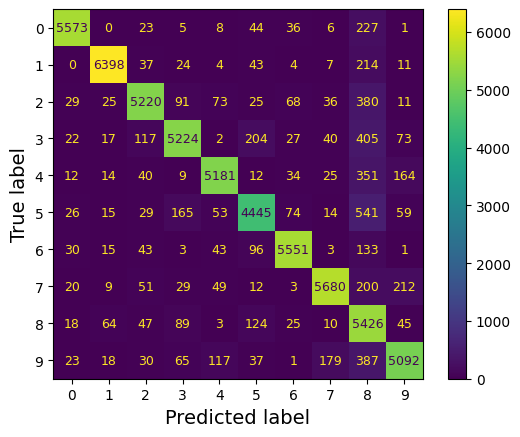

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

- The initial confusion matrix shows strong overall performance
  - most values lie along the main diagonal
  - indicates most digits are classified correctly

- The diagonal cell at row 5, column 5 appears darker
  - this could mean:
    - the model makes more errors on digit 5
    - or there are simply fewer images of digit 5 in the dataset

- Raw confusion matrices can be misleading when class frequencies differ

- To fairly compare errors across classes:
  - normalize the confusion matrix
  - divide each row by the total number of true instances of that class

- Normalization converts raw counts into proportions or percentages
  - allows error rates to be compared across classes

- In Scikit-Learn:
  - set normalize="true" to normalize by true class counts
  - use values_format=".0%" to display percentages without decimals

- The normalized confusion matrix highlights:
  - which digits are most frequently confused
  - genuine weaknesses of the classifier rather than class imbalance effects


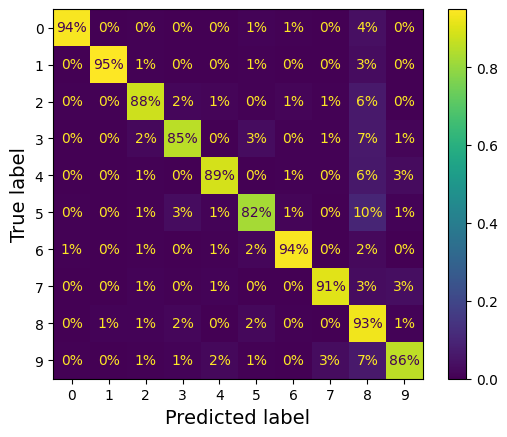

In [104]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

- The normalized confusion matrix shows that:
  - only about 82% of digit 5 images are classified correctly

- The most frequent error for digit 5:
  - misclassification as digit 8
  - occurs for about 10% of all 5s

- Confusion matrices are not symmetrical:
  - while 10% of 5s are classified as 8s
  - only about 2% of 8s are misclassified as 5s

- This asymmetry reveals directional confusion:
  - “5 → 8” errors are much more common than “8 → 5” errors

- From the matrix, many digits are misclassified as 8s
  - but this pattern is not immediately obvious
  - because correct predictions on the diagonal dominate the visualization

- To make errors more visible:
  - suppress or zero out correct predictions on the diagonal
  - this highlights only the misclassifications

- Visualizing errors alone helps:
  - identify which digits the model confuses most
  - guide targeted improvements (e.g., feature engineering or data augmentation)


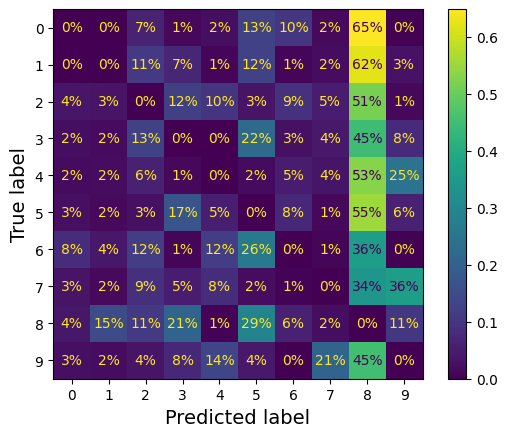

In [105]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

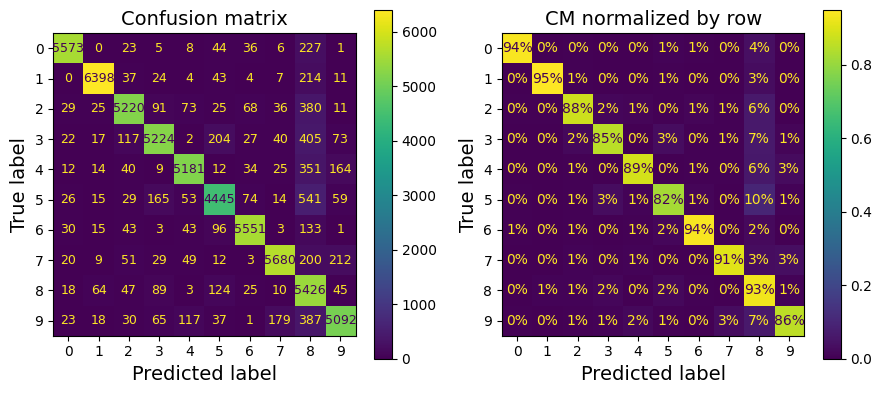

In [106]:
# extra code – this cell generates and saves Figure 3–9
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

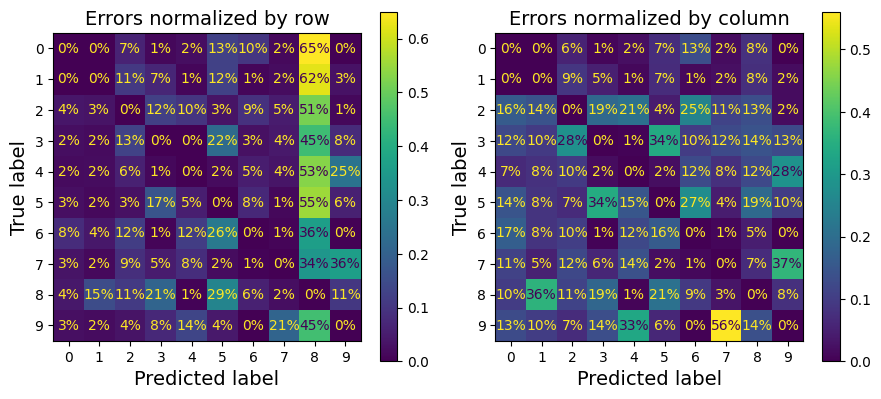

In [107]:
# extra code – this cell generates and saves Figure 3–10
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

- With correct predictions removed, error patterns become much clearer
  - the column for digit 8 is very bright
  - this shows that many images from different classes are misclassified as 8
  - digit 8 is the most common wrong prediction across classes

- Be careful interpreting percentages in this error-only confusion matrix
  - percentages are relative to errors, not total samples
  - example: 36% in row 7, column 9 means:
    - 36% of the errors made on digit 7 were predictions of 9
    - not that 36% of all 7s were misclassified as 9
  - in reality, only about 3% of all 7s were misclassified as 9

- Confusion matrices can also be normalized by predicted classes
  - using normalize="pred"
  - columns sum to 1 instead of rows
  - this shows, for a given predicted class, where the errors came from
  - example: 56% of misclassified predictions of 7 are actually 9s

- Error analysis reveals concrete directions for model improvement
  - the main weakness here is excessive false predictions of 8s

- Possible improvement strategies:
  - collect more training data for digits that resemble 8 but are not 8
  - engineer new features (e.g., count closed loops: 8→2, 6→1, 5→0)
  - preprocess images to emphasize important patterns
    - using tools like Scikit-Image, Pillow, or OpenCV

- Analyzing individual misclassified examples is also valuable
  - helps understand *why* the model fails
  - provides intuition about decision boundaries
  - next step: visualize specific confusions (e.g., 3 vs 5) in a confusion-matrix-style plot


In [108]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

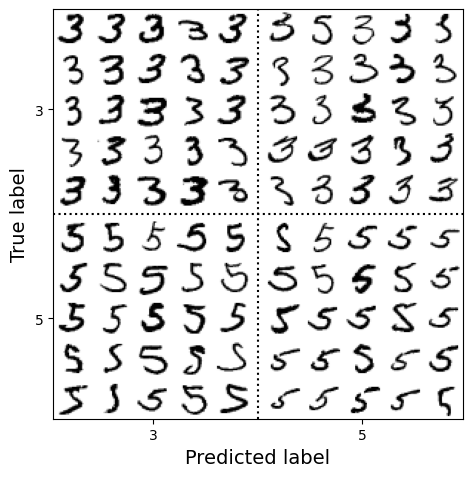

In [109]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

- Some misclassified digits are genuinely hard to recognize
  - even humans would struggle with badly written examples
  - these appear in the off-diagonal blocks of the confusion-style plots

- However, many errors look obvious to humans
  - this can be misleading
  - human vision performs complex preprocessing automatically

- The task only feels simple because:
  - the human brain is extremely powerful at pattern recognition
  - much processing happens before conscious perception

- The model used here is an SGDClassifier:
  - it is a linear model
  - assigns a weight to each pixel for each class
  - computes class scores by summing weighted pixel intensities

- Because digits like 3 and 5 differ only in a few pixels:
  - a linear model easily confuses them
  - small changes in pixel position can flip the prediction

- A key visual difference between 3 and 5:
  - the position of the small connecting stroke
  - slight shifts can make a 3 look like a 5 and vice versa

- This shows the model is sensitive to:
  - image shifting
  - image rotation

- Possible ways to reduce 3/5 confusion:
  - preprocess images to center and align them
  - rotation correction (hard to implement reliably)

- A simpler and more effective solution:
  - augment the training data with shifted and rotated versions
  - forces the model to learn invariance to these transformations

- This technique is called data augmentation
  - improves robustness
  - covered in detail in later chapters


# Multilabel Classificatio

- So far, each instance has been assigned to exactly one class
  - this is standard multiclass classification

- In some applications, an instance may belong to multiple classes at once

- Example: face recognition
  - a single image may contain several people
  - the classifier should assign one label per person

- If the system recognizes three people:
  - Alice, Bob, Charlie
  - and the image contains Alice and Charlie
  - the correct output would be:
    - [True, False, True]

- Each position in the output corresponds to one label
  - True → person is present
  - False → person is not present

- A system that predicts multiple binary labels for each instance is called:
  - a multilabel classification system

- Multilabel classification differs from multiclass classification:
  - multiclass → exactly one class per instance
  - multilabel → zero, one, or multiple classes per instance

- The next step is to illustrate multilabel classification with a simpler example


In [110]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


- A multilabel target array is created where each image has two labels:
  - first label → whether the digit is large (7, 8, or 9)
  - second label → whether the digit is odd

- Each instance therefore has multiple binary targets
  - example: digit 5 → [False, True]
    - not large
    - odd

- A KNeighborsClassifier is used:
  - it supports multilabel classification
  - not all classifiers can handle multilabel outputs

- The model is trained using the multilabel target array
  - each training instance maps to multiple labels

- When making a prediction:
  - the classifier outputs multiple labels for a single instance
  - the prediction for digit 5 is correct:
    - False for large
    - True for odd

- Evaluating multilabel classifiers depends on the task
  - there is no single universally best metric

- A common evaluation approach:
  - compute a binary metric (e.g., F1 score) separately for each label
  - then average the scores across all labels

- This averaged F1 score provides an overall measure of multilabel performance


In [111]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [112]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [113]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

- Averaging F1 scores across labels assumes all labels are equally important
  - this may not be appropriate in real-world datasets
  - some labels may appear far more frequently than others

- When label importance differs:
  - labels with more instances (higher support) should have more influence
  - support = number of samples associated with a label

- A simple solution is weighted averaging:
  - set average="weighted" in f1_score()
  - this weights each label’s score by its support
  - more frequent labels contribute more to the final score

- Some classifiers (e.g., SVC) do not natively support multilabel classification
  - a basic workaround is to train one binary classifier per label

- Limitation of training one model per label:
  - label dependencies are ignored
  - example:
    - “large digit” (7, 8, 9) is correlated with “odd digit”
    - independent classifiers cannot exploit this relationship

- To capture label dependencies:
  - models can be arranged in a chain
  - each model receives:
    - original input features
    - predictions from previous models in the chain

- This approach is called classifier chaining

- Scikit-Learn provides ChainClassifier:
  - automatically implements classifier chains
  - by default:
    - uses true labels during training
  - with cv parameter:
    - uses cross-validation
    - generates out-of-sample (“clean”) predictions
    - avoids data leakage between chained models

- For efficiency in examples:
  - training is often limited to a subset (e.g., first 2,000 samples)


In [114]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator estimator: estimatorThe base estimator from which the classifier chain is built.,SVC()
,"order order: array-like of shape (n_outputs,) or 'random', default=NoneIf `None`, the order will be determined by the order of columns inthe label matrix Y.:: order = [0, 1, 2, ..., Y.shape[1] - 1]The order of the chain can be explicitly set by providing a list ofintegers. For example, for a chain of length 5.:: order = [1, 3, 2, 4, 0]means that the first model in the chain will make predictions forcolumn 1 in the Y matrix, the second model will make predictionsfor column 3, etc.If order is `random` a random ordering will be used.",None
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines whether to use cross validated predictions or truelabels for the results of previous estimators in the chain.Possible inputs for cv are:- None, to use true labels when fitting,- integer, to specify the number of folds in a (Stratified)KFold,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.",3
,"chain_method chain_method: {'predict', 'predict_proba', 'predict_log_proba', 'decision_function'} or list of such str's, default='predict'Prediction method to be used by estimators in the chain forthe 'prediction' features of previous estimators in the chain.- if `str`, name of the method;- if a list of `str`, provides the method names in order of preference. The method used corresponds to the first method in the list that is implemented by `base_estimator`... versionadded:: 1.5",'predict'
,"random_state random_state: int, RandomState instance or None, optional (default=None)If ``order='random'``, determines random number generation for thechain order.In addition, it controls the random seed given at each `base_estimator`at each chaining iteration. Thus, it is only used when `base_estimator`exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: bool, default=FalseIf True, chain progress is output as each model is completed... versionadded:: 1.2",False
,"base_estimator base_estimator: estimator, default=""deprecated""Use `estimator` instead... deprecated:: 1.7 `base_estimator` is deprecated and will be removed in 1.9. Use `estimator` instead.",'deprecated'
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


In [115]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification

- Multioutput multiclass classification (often called multioutput classification)
  - is a generalization of multilabel classification
  - each instance has multiple labels
  - each label can take more than two possible values

- In multilabel classification:
  - each label is binary (True/False)

- In multioutput classification:
  - each label can be multiclass
  - labels may have many possible values

- Example: image denoising system
  - input: a noisy handwritten digit image
  - output: a clean version of the same image

- The output structure:
  - one label per pixel
  - each label is a pixel intensity value
  - possible values range from 0 to 255

- Why this is multioutput classification:
  - multilabel → one label per pixel
  - multiclass → each pixel can take many values
  - therefore: multioutput + multiclass

- To build the dataset:
  - start with MNIST images
  - add random noise to pixel intensities using NumPy’s randint()
  - noisy images are used as inputs
  - original clean images are used as targets

- Goal of the model:
  - learn to map noisy images to clean images
  - effectively remove noise from each pixel


- The distinction between classification and regression is not always strict

- In some problems, such as image denoising:
  - predicting pixel intensities (0–255) can be seen as regression
  - even though the problem is framed as classification

- This shows that the boundary between:
  - classification tasks
  - regression tasks
  can be blurry in practice

- Multioutput systems are more general than just classification
  - they can produce multiple outputs per instance

- These outputs can be:
  - multiple class labels
  - continuous values
  - or a mix of both

- Therefore, a multioutput system may combine:
  - classification objectives
  - regression objectives
  in a single model


In [116]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

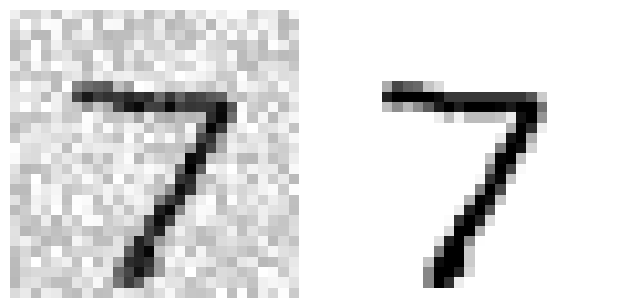

In [117]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

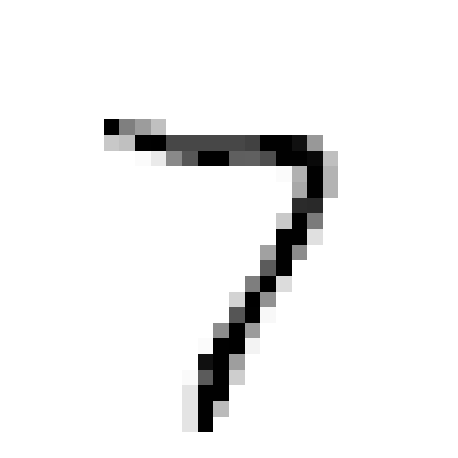

In [118]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()

# Exercise

## 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters)

In [119]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

In [120]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",KNeighborsClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3

In [121]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [122]:
grid_search.best_score_

np.float64(0.9441999999999998)

In [123]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

## 2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.⁠ Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growingthe training set is called data augmentation or training set expansion.

In [124]:
from scipy.ndimage import shift

In [125]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

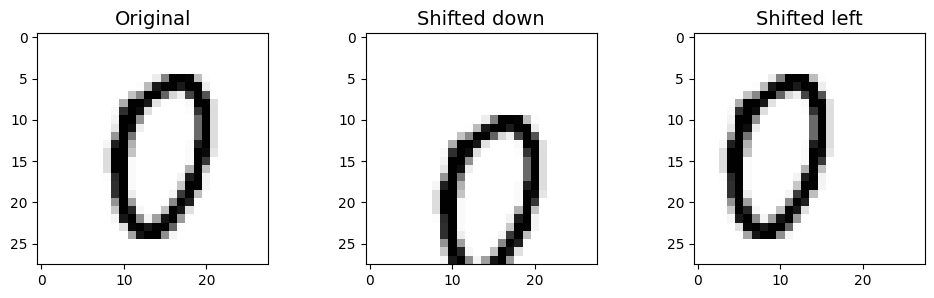

In [126]:
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [127]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [128]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [129]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [130]:
knn_clf.fit(X_train_augmented, y_train_augmented)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",4
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [131]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [132]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


## 3. Tackle the Titanic dataset. A great place to start is on Kaggle.
    Alternatively, you can download the data from
    https://homl.info/titanic.tgz and unzip this tarball like you did for the
    housing data in Chapter 2. This will give you two CSV files, train.csv
    and test.csv, which you can load using pandas.read_csv(). The goal is to
    train a classifier that can predict the Survived column based on the other
    columns.

In [133]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [134]:
train_data, test_data = load_titanic_data()

C:\Users\roush\AppData\Local\Temp\ipykernel_26136\1736236013.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  titanic_tarball.extractall(path="datasets")


In [135]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [137]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [138]:
train_data[train_data["Sex"]=="female"]["Age"].median()

np.float64(27.0)

Okay, the Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The Name and Ticket attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

In [139]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [140]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [141]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [142]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [143]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

**Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:**

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [146]:
num_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a f

In [145]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [147]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [148]:
cat_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ordinal_encoder', ...), ('imputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute.",'auto'
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'use_encoded_value'}, default='error'When set to 'error' an error will be raised in case an unknowncategorical feature is present during transform. When set to'use_encoded_value', the encoded value of unknown categories will beset to the value given for the parameter `unknown_value`. In:meth:`inverse_transform`, an unknown category will be denoted as None... versionadded:: 0.24",'error'
,"unknown_value unknown_value: int or np.nan, default=NoneWhen the parameter handle_unknown is set to 'use_encoded_value', thisparameter is required and will set the encoded value of unknowncategories. It has to be distinct from the values used to encode any ofthe categories in `fit`. If set to np.nan, the `dtype` parameter mustbe a float dtype... versionadded:: 0.24",None
,"encoded_missing_value encoded_missing_value: int or np.nan, default=np.nanEncoded value of missing categories. If set to `np.nan`, then the `dtype`parameter must be a float dtype... versionadded:: 1.1",nan
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.3 Read more in the :ref:`User Guide `.",None
,"max_categories max_categories: int, default=NoneSpecifies an upper limit to the number of output categories for each inputfeature when considering infrequent categories. If there are infrequentcategories

In [149]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [150]:
preprocess_pipeline

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [151]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]], shape=(891, 12))

In [152]:
y_train = train_data["Survived"]

In [153]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [154]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [155]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

np.float64(0.8137578027465668)

In [156]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

np.float64(0.8249313358302123)

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is  Q1  and the upper quartile is  Q3 , then the interquartile range  IQR=Q3−Q1  (this is the box's height), and any score lower than  Q1−1.5×IQR  is a flier, and so is any score greater than  Q3+1.5×IQR .

C:\Users\roush\AppData\Local\Temp\ipykernel_26136\3995193800.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))


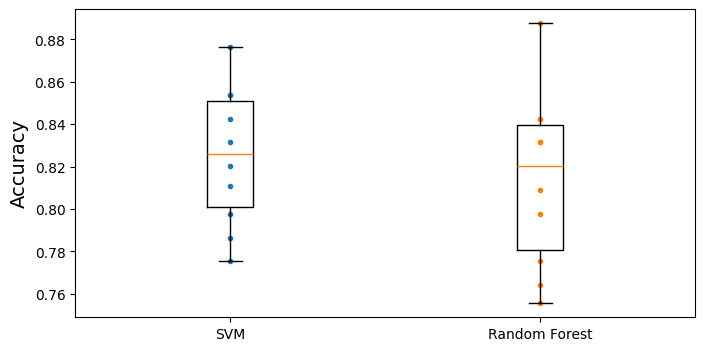

In [157]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, you could:

Compare many more models and tune hyperparameters using cross validation and grid search,
Do more feature engineering, for example:
Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
Replace SibSp and Parch with their sum.
Try to identify parts of names that correlate well with the Survived attribute.
Use the Cabin column, for example take its first letter and treat it as a categorical attribute.

In [158]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [159]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. Build a spam classifier (a more challenging exercise):
> 1. Download examples of spam and ham from Apache
    SpamAssassin’s public datasets.

> 2. Unzip the datasets and familiarize yourself with the data format.

> 3. Split the data into a training set and a test set.

> 4. Write a data preparation pipeline to convert each email into a
    feature vector. Your preparation pipeline should transform an email
    into a (sparse) vector that indicates the presence or absence of each
    possible word. For example, if all emails only ever contain four
    words, “Hello”, “how”, “are”, “you”, then the email “Hello you
    Hello Hello you” would be converted into a vector [1, 0, 0, 1]
    (meaning [“Hello” is present, “how” is absent, “are” is absent,
    “you” is present]), or [3, 0, 0, 2] if you prefer to count the number
    of occurrences of each word.
    You may want to add hyperparameters to your preparation pipeline
    to control whether or not to strip off email headers, convert each
    email to lowercase, remove punctuation, replace all URLs with
    “URL”, replace all numbers with “NUMBER”, or even perform
    stemming (i.e., trim off word endings; there are Python libraries
    available to do this).


> 5. Finally, try out several classifiers and see if you can build a great
    spam classifier, with both high recall and high precision.

In [160]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [161]:
ham_dir, spam_dir = fetch_spam_data()

C:\Users\roush\AppData\Local\Temp\ipykernel_26136\1017635056.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


In [162]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [163]:
len(ham_filenames)

2500

In [164]:
len(spam_filenames)

500

In [165]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [166]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [167]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [168]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [169]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [170]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [171]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [172]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [173]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [174]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [175]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [176]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\roush\AppData\Local\Temp\ipykernel_26136\3203418293.py:6: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)


In [177]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [178]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [179]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [180]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [182]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [184]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [185]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [186]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose fit() method will build the vocabulary (an ordered list of the most common words) and whose transform() method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [187]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [188]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20 stored elements and shape (3, 11)>

In [189]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [190]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

np.float64(0.985)

In [192]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 95.88%
Recall: 97.89%
